**Build Image**

Build a simple 3 x 3 image with the following values:

img = [0.00 0.16 0.33
       0.16 0.33 0.50
       0.33 0.50 0.66]


[[ 0.          0.16666667  0.33333333]
 [ 0.16666667  0.33333333  0.5       ]
 [ 0.33333333  0.5         0.66666667]]


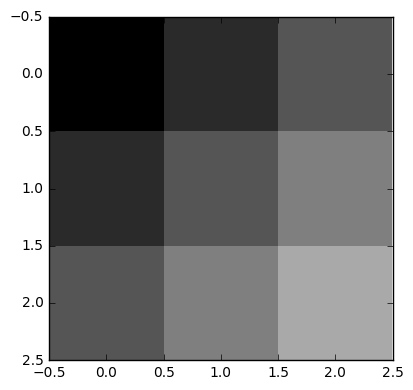

In [30]:
import numpy as np
from math import ceil

%matplotlib inline
from numpy import ogrid, repeat, newaxis
from skimage import io

imsize = 3.
x, y = ogrid[:imsize, :imsize]
img = (x + y)/(imsize + imsize)
print img
io.imshow(img, interpolation='none', cmap='gray')

Now, in order to upsample this grid by 3, we need to pad the grid with zeros:

In [33]:
# let f be the upsampling factor
f = 3 # We'll see bellow that it's possible to 
# calculate this factor from the filter width
# let I be the padded image
I_shape = (9,9)
I = np.zeros(I_shape)
I[1::f, 1::f] = img
print I

[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.16666667  0.          0.
   0.33333333  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.16666667  0.          0.          0.33333333  0.          0.
   0.5         0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.33333333  0.          0.          0.5         0.          0.
   0.66666667  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]]


Now, the game is to upsample the image above using a 2d convolution 
and a bilinear filter. How to do this?
A bilinear filter in 1d looks as follow:

f(x) = 1 - |x| for |x| < 1, 
     = 0 elsewhere
     
Then, in 2d it's a 2d triangle that looks like this:     
f(x,y) = (1 - |x|) * (1 - |y|) for |x| < 1, |y| < 1,
       = 0 elsewhere
       
So, in order to build a bilinear upsampling kernel the following as to be done:

In [34]:
 def upsample_filter(f_shape):
    width = f_shape[0]
    heigh = f_shape[1]
    f = ceil(width/2.0)
    c = (2 * f - 1 - f % 2) / (2.0 * f)
    bilinear = np.zeros([f_shape[0], f_shape[1]])
    for x in range(width):
        for y in range(heigh):
            bilinear[x, y] = (1 - abs(x / f - c)) * (1 - abs(y / f - c))
            
    return bilinear

f_shape = (5,5)
filter = upsample_filter(f_shape)
print filter

[[ 0.11111111  0.22222222  0.33333333  0.22222222  0.11111111]
 [ 0.22222222  0.44444444  0.66666667  0.44444444  0.22222222]
 [ 0.33333333  0.66666667  1.          0.66666667  0.33333333]
 [ 0.22222222  0.44444444  0.66666667  0.44444444  0.22222222]
 [ 0.11111111  0.22222222  0.33333333  0.22222222  0.11111111]]


Now that we have the filter with shape f_filter and the padded image I with shape I_shape,
we can upsample the image I ( == padded img) using a convolution with filter 'filter'

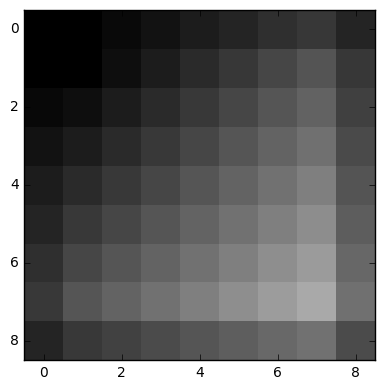

In [38]:
import tensorflow as tf

# The padded image
x_shape = (9,9)
x = np.zeros(x_shape)
x[1::f, 1::f] = img

# The filter
w_shape = (5,5)
w = upsample_filter(w_shape)

# signal dimension
N = 1; C = 1; H = 9; W = 9;

# filter dimensions
F = 1; C = 1; Hh = 5; Ww = 5;

# Convolution (S)tride and (P)ad
S = 1; P = 1;

# shape of the padded image
x_shape = (N,C,H,W)

# shape of the filter
w_shape = (F,C,Hh,Ww)

# expand signal dimensions (H, W) ---> (N,C,H,W)
x = x[None, None, ...]

# expand filter dimensions (Hh, Ww) ---> (F, C, Hh, Ww)
w = w[None, None, ...]

# convert to format accepetd by tf
x = np.transpose(x,[0, 2, 3, 1]) # convert to format NHWC accepetd by tf
w = np.transpose(w,[2, 3, 1, 0]) # convert to format HWCF accepted by tf

conv2d_graph = tf.Graph()

with conv2d_graph.as_default():
    # define placeholders to tf
    tf_x = tf.Variable(x, name="x", dtype=tf.float32)
    tf_w = tf.Variable(w, name="w", dtype=tf.float32)

    # build graph
    conv = tf.nn.conv2d(tf_x, tf_w, strides=[1, S, S, 1], padding="SAME", data_format="NHWC")

    # init graph
    init = tf.initialize_all_variables()
    session = tf.Session()
    session.run(init)

    # run session
    result = session.run(conv)
    session.close()

    result = np.transpose(result, [0, 3, 1, 2]) # convert to format NCHW - more readable format!

    img_conv2d = result[0, 0, :, :]
    io.imshow(img_conv2d, interpolation='none', cmap='gray')
    # print 'result = ', img_conv2d

Now let's do the same **without** convolution, only by using an upsampling 
convolution:

True

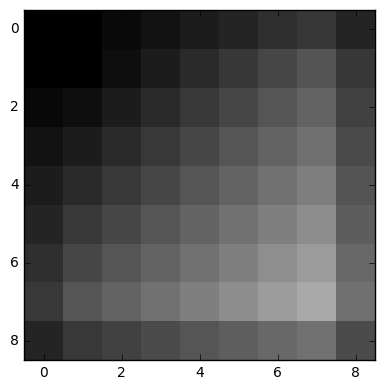

In [39]:
import skimage.transform

def upsample_skimage(factor, input_img):
    
    # Pad with 0 values, similar to how Tensorflow does it.
    # Order=1 is bilinear upsampling
    return skimage.transform.rescale(input_img,
                                     factor,
                                     mode='constant',
                                     cval=0,
                                     order=1)


upsampled_img_skimage = upsample_skimage(factor=3, input_img=img)
# print sub_upsampled_img_skimage
io.imshow(upsampled_img_skimage, interpolation='none')

# Test if the results of upsampling are the same
np.allclose(upsampled_img_skimage, img_conv2d)




**Transposed Convolution**

Let's now check how we do that with transposed convoution in tf.
In fact, what we want to prove is that conv2d(0 padded img, filter) == conv2d_transposed(img, filter)?
When you use transposed convolution, you don't need to pad the input image

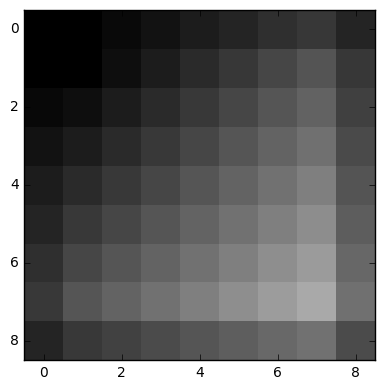

In [44]:
# The original image (no need to pad it)
x = img

# The filter
w_shape = (5,5)
w = upsample_filter(w_shape)

# signal dimension
N = 1; C = 1; H = 3; W = 3;

# filter dimensions
F = 1; C = 1; Hh = 5; Ww = 5;

# Convolution (S)tride and (P)ad
S = 1; P = 1;

# shape of the padded image
x_shape = (N,C,H,W)

# shape of the filter
w_shape = (F,C,Hh,Ww)

# expand signal dimensions (H, W) ---> (N,C,H,W)
x = x[None, None, ...]

# expand filter dimensions (Hh, Ww) ---> (F, C, Hh, Ww)
w = w[None, None, ...]

# convert to format accepetd by tf
x = np.transpose(x,[0, 2, 3, 1]) # convert to format NHWC accepetd by tf
w = np.transpose(w,[2, 3, 1, 0]) # convert to format HWCF accepted by tf

conv2d_t_graph = tf.Graph()

with conv2d_t_graph.as_default():
    # define placeholders to tf
    tf_x = tf.Variable(x, name="x", dtype=tf.float32)
    tf_w = tf.Variable(w, name="w", dtype=tf.float32)

    # transposed convolution
    factor = 3 # upsample the image by 3
    out_height = img.shape[0] * factor
    out_width  = img.shape[1] * factor
    num_class = C
    

    conv_t = tf.nn.conv2d_transpose(tf_x, 
                                    tf_w, 
                                    output_shape=[1, out_height, out_width, num_class], 
                                    strides = [1, factor, factor, 1])

    init = tf.initialize_all_variables()

    session = tf.Session()
    # init graph
    session.run(init)
    # run session
    result = session.run(conv_t)
    result = np.transpose(result, [0, 3, 1, 2]) # convert to format NCHW - more readable format!
    session.close()

    img_conv2d_t = result[0, 0, :, :]
    io.imshow(img_conv2d_t, interpolation='none', cmap='gray')

In [45]:
# check the difference between conv2d and conv2d_transposed
np.allclose(img_conv2d_t, img_conv2d)

True